#  Comparison of L1 minimization, IHT and NSIHT algorithms for Compressed Sensing 


L1 minimization, IHT and NSIHT are algorithms for compressed sensing which are used to recover the signal x after it undergoes the measurement matrix A to obtain the signal y. 
The obtained signal y is related to the vector x by the equation:
$$
y=Ax
$$



Here, x is a sparse vector of sparsity s of the order Nx1. A is the measurement matrix mxN. When the sparse vector x undergoes the measurement matrix, we obtain the vector y. 
This signal that we have obtained is now used to recover the original signal x. This can be done by various different algorithms, some of which are discussed in this project.

In this project, we try to determine the performance and efficiency of the three algorithms by comparing them in terms of the probability of recovery of the signal x and the relative errors between the original vector x and the vector recovered from y.


Throughout this tutorial, we show the implementation of the three algorithms. We write the codes in python to implement the algorithms using various libraries in python. 

NOTATION USED:

A is an mxN random gausian measurement matrix.

s is the sparsity level 

x is a Nx1 vector with a sparsity s.

y is obtained by solving y=Ax.

A_trans is the transpose matrix of the matrix A.

I is the identity matrix of the order mxN.

H(s) is the hard thresholding function that turns all values other than the s largest values to be zero. 

h is the step size for the iterations in IHT and NSIHT

import all the libraries required for the project 

In [1]:
import numpy as np
import math
import random
from random import seed
from random import random
from numpy import linalg as LA
import scipy.linalg.interpolative
import random
import matplotlib.pyplot as plt
import cvxpy as cp
from IPython.core.display import display, HTML
import statistics

C:\Users\Shamita\AppData\Local\Temp\ipykernel_7932\3756934004.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## L1 minimization

L1 minimization or basic pursuit is an optimization method. It is a convex problem that can be described as:
$$
minimize\; ||z||_{1}    \;\;\;  \;\;subject \;\;to\;\;\; Az=y
$$

Input: $$measurement\; matrix\; A,\; measurement\; vector\; y,\; sparsity\; s $$

Instruction:
$$
x^n =argmin||z||_{1} \;\; subject\;  to\;\;  Az=y
$$

Output:
$$ 
s \;sparse\; vector\; x^n
$$

In [2]:
def l1_minimization(m,N,s,N_mc):
    
    probability=[]
    m_val=[]
    diff_l1=[]
    diff_it=[]
    val=[]
    for m in range (20,m,20):
        succ=0  #initialize succesful attempts as 0

        m_val.append(m)  #the vector m_val stores the values of m for every iteration
        
        for i in range(N_mc):  #for every iteration, generate a new measurement matrix, x vector and corresponding vector y
            A=np.random.randn(m,N) 
            x =np.zeros((N,1))

            import random
            randomlist = random.sample(range(0, N-1), s)  # indeces for non zero values

            from random import random

            for i in randomlist:
                x[i]=random()   #putting random non zero, s values to define vector x 

            y=A.dot(x)  # calculating the corresponding vector 

            
            # to solve argmin ||z|| subject to Az = y
            z_n= cp.Variable((N,1))
            z=cp.norm(z_n,1)

            prob = cp.Problem(cp.Minimize(z),[A@z_n==y])  #min  z st A*z_n=y
            prob.solve(abstol=1e-15) 

            z_star=hard_thresh(z_n.value,s) #values for the vector after minimization

            if (LA.norm((x-z_star),2)/LA.norm(x,2))<1e-3: #determinimg success if the values are satisfed
                succ=succ+1

            # finding the difference between actual and calculated values of x to determine relaive error
            diff=z_star-x 
            val.append(LA.norm(diff))
            diff_l1.append(LA.norm(diff))
        
        probability.append(succ/N_mc) #calculating the probability dependig on the number of successful iterations
    
    return m_val,probability,diff_l1     


## Iterative Hard Thresholding (IHT)

In the IHT algorithm, we begin with an initial signal x and it undergoes the iterations as described below till the required value of the vector is obtained. The IHT algorithm can be described as:


Input: $$measurement\; matrix\; A,\; measurement\; vector\; y,\; sparsity\; s ,\; step\;size\;h$$


Initialization: $$ s \;sparse \;x^0\; initially \;set \;to\; 0 $$

Iteration: repeat the steps until a stopping criteria is met
$$
x_{n+1} = H_s(x_n +h A^\top(y-Ax_n))
$$

Output: the s sparse vector $$x_{n+1}=x_{n}$$

For this algorithm, we consider the stopping criteria to be as long as the number of iterations do not exceed the maximum number of iterations and the tolerence limit is met.

Relative increment:
$$ \frac{|| x_{n+1}-x_{n}||}{|| x_{n+1} ||} $$

In [3]:
def iht_algo (A,y,s,h,max_iter,tol,xn,x,N):
    iteration=0
    rel_incr=10       
    xn1=np.zeros((N,1))  
    
    #the while loop is run till the no of iterations if less than maximum iteration and relative increment greater then the tolerance
    
    while iteration<max_iter and rel_incr>tol:
        
        # x[n+1] = Hs(x[n]+h A_trans(y-Ax[n]))
        A_trans=A.transpose() # A transpose
        xn1=xn+(h*(A_trans.dot((y-(A.dot(xn))))))  #x[n+1]
        xn1=hard_thresh(xn1,s)  #hard threshold for x[n+1]
        
        rel_incr=LA.norm(xn1-xn)/LA.norm(xn1) # realtive increment 
        iteration=iteration+1
        
        xn=xn1 # replace xn with x[n+1] and continue the loop
           
    return xn

In [4]:
def IHT(N,m,s,N_mc,h):
    prob=[]
    m_val=[]
    residual=[]
    diff_iht=[]
    
    for m in range (20,m,20):
        succ=0     #initialize succesful attempts as 0
        m_val.append(m)

        for iter_mc in range(N_mc):
            #for every iteration, generate a new measurement matrix, x vector and corresponding vector y
            
            A=np.random.randn(m,N)  
            x =np.zeros((N,1))
            a=LA.norm(A,2)
            A=A/(a)
            
            import random
            randomlist = random.sample(range(0, N-1), s) # indeces for non zero values
            from random import random
        
            for i in randomlist:
                x[i]=random()   #putting random non zero, s values to define vector x 

            y=A.dot(x)  # calculating the corresponding vector y

            xn=np.zeros((N,1))  # initialize xn as zero vector
            xnplus1=iht_algo(A,y,s,h,100,1e-8,xn,x,N)  #iht algorithm
            
            # finding the difference between actual and calculated values of x to determine relaive error
            diff=xnplus1-x
            diff_iht.append(LA.norm(diff))
            
            residual.append(LA.norm((A.dot(xnplus1))-y))
        
            if (LA.norm((x-xnplus1),2)/LA.norm(x,2))<1e-3:  #determining the success
                succ=succ+1

        prob.append(succ/N_mc)  #calculating the probability dependig on the number of successful iterations
        
    return m_val,prob,diff_iht,residual

## Newton Step based Iterative Hard Thresholding (NSIHT)

NSIHT algorithm is based on the IHT algorithm with some improvements in the equation for a better and more accurate output.
It can be described as:

Input: $$ measurement\; matrix\; A, \;measurement\; vector\; y, \;sparsity\; s, \;stepsize\; \lambda\; and\; parameter\; \epsilon$$

Iteration: $$x_{p+1}=K_{s}[x^p+\lambda(A^TA+ \epsilon I)^{-1}A^T(y-Ax^p)]
$$

Output: s sparse vector $$x^*$$

In [5]:
def nsiht_algo (A,y,s,e,h,max_iter,xn,x,tol,N):
    iteration=0
    rel_incr=10
    
    I=np.identity(N)  #identity matrix
    xn1=np.zeros((N,1)) #initialize x[n+1] as zero vector
    
    #the while loop is run till the no of iterations if less than maximum iteration and relative increment greater then the tolerance  
    while iteration<max_iter and rel_incr>tol:
        
        A_trans=A.transpose()
        inv=(A_trans.dot(A))+(e*I)
        inv=np.linalg.inv(inv) 
        
        #nsiht algorithm
        xn1=xn+(h*inv.dot((A_trans.dot(y-A.dot(xn)))))      
        xn1=hard_thresh(xn1,s)
       
        rel_incr=LA.norm(xn1-xn)/LA.norm(xn1) # realtive increment
        iteration=iteration+1      
        xn=xn1    # replace xn with x[n+1] and continue the loop
           
    return xn 

In [6]:
def NSIHT (N,m,s,N_mc,e,h):
    prob=[]
    m_val=[]
    diff_nsiht=[]
    residual=[]
    
    for m in range (20,m,20):
        succ=0    #initialize succesful attempts as 0
        m_val.append(m)
        
        for iter_mc in range(N_mc):
        #for every iteration, generate a new measurement matrix, x vector and corresponding vector y
        
            A=np.random.randn(m,N)  
            x =np.zeros((N,1))
            a=LA.norm(A,2)
            A=A/(a)
            xminusxnorm=[]
            import random
            randomlist = random.sample(range(0, N-1), s) # indeces for non zero values
            from random import random

            for i in randomlist:
                x[i]=random()    #putting random non zero, s values to define vector x 

            y=A.dot(x)      # calculating the corresponding vector y
            
            xn=np.zeros((N,1))  # initialize vectors x[n] and x[n+1] as zero vector
            xn1=np.zeros((N,1)) 

            x_star=nsiht_algo(A,y,s,e,h,700,xn,x,1e-6,N)   #nsiht algorithm

            if (LA.norm((x-x_star),2)/LA.norm(x,2))<1e-3:  #determining the success
                        succ=succ+1
                    
            # finding the difference between actual and calculated values of x to determine relaive error
            diff=x_star-x
            diff_nsiht.append(LA.norm(diff))
            residual.append(LA.norm((A.dot(x_star))-y))
        
        prob.append(succ/N_mc)  #calculating the probability dependig on the number of successful iterations
        
    return m_val,prob,diff_nsiht,residual

In this project, we run the algorithms for N_mc number of times (no of monte carlo experiments) for different values of m for the measurement matrix. 
This helps us understand the probability of success recovery by calculating the number of succesful recoveries. Similarly, we calculate the relative error for different values of m which shows the different of recovered vector x[n+1] and the true values of the vector x.

Define a function hard_thresh for hard thresholding with the inputs as vector and sparsity. This function returns the s largest absolute values of the vector.

In [7]:
def hard_thresh(x_vec,s):  #input vector x_vec and sparsity level s
    n=len(x_vec) #length of the vector
    val=[]   #empty list to store the indices of s largest elements in x_vec
    
    x_vec_temp=np.array  #store vecor in temporary vector
    x_vec_temp=np.absolute(x_vec)  #store absolute values of vector
    ind=x_vec_temp.argsort(axis=0) #indices of absolute values arranged in order
    
    val=ind[-s:] #indices of s largest values
    
    for i in range(n):
        if i not in val:
            x_vec[i]=0 #values at all indices other than the s largest elements set too zero
      
    return(x_vec)

Compare the three algorithms with respect to the values of m with respect to different levels of sparsity

# Parameters for comparrison

1. RELATIVE ERROR $$ ||(x_{n}-x)||$$
2. RESIDUAL $$||Ax^n-y||$$
3. PROBABILITY OF RECOVERY $$\frac{accurate \; recoveries}{total \;attempts}$$

PROBABILITY OF RECOVERY AND AVERAGE RELATIVE ERROR AT DIFFERENT VALUES OF SPARSITY FOR L1 min vs IHT vs NSIHT

sparsity= 2


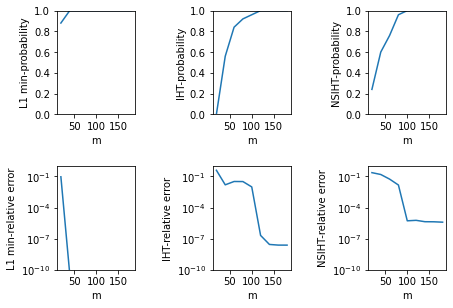

sparsity= 3


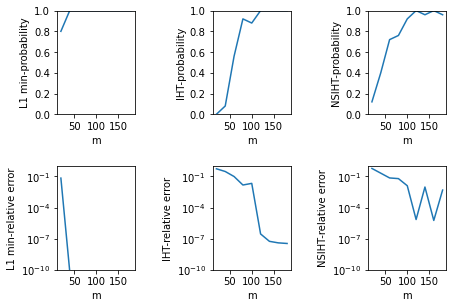

sparsity= 4


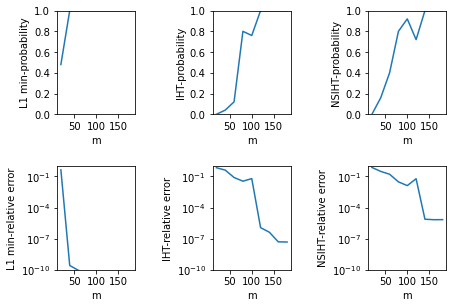

sparsity= 5


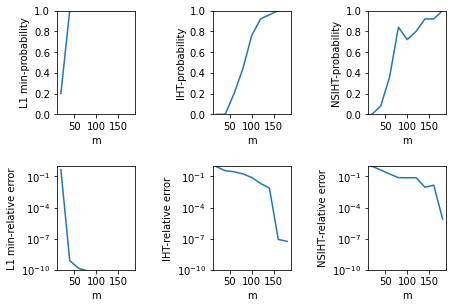

sparsity= 6


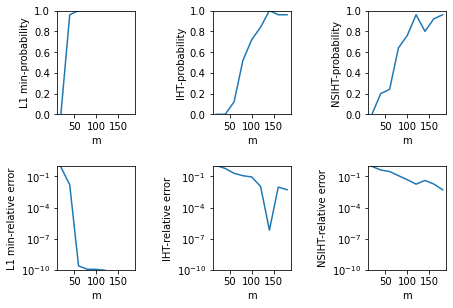

sparsity= 7


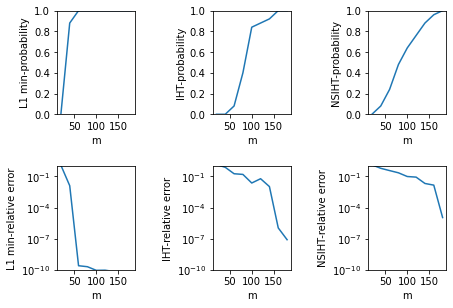

In [8]:
N_mc=25
s_values=[2,3,4,5,6,7]

print('\033[1m' +"PROBABILITY OF RECOVERY AND AVERAGE RELATIVE ERROR AT DIFFERENT VALUES OF SPARSITY FOR L1 min vs IHT vs NSIHT" )
print('')
for spars in s_values:
    
    
    print('sparsity=',(spars))
    
    m_val,prob_l1,diff_l1 =l1_minimization(200,200,spars,25)
    m_iht1,prob_iht1,diff_iht1,resi_iht1=IHT(200,200,spars,25,1)
    m_nsiht1,prob_nsiht1,diff_nsiht1,resi_nsiht1=NSIHT(200,200,spars,25,1,1) 

       

    l1_err= [diff_l1[i:i+N_mc] for i in range(0, len(diff_l1), N_mc)]
    iht_err = [diff_iht1[i:i+N_mc] for i in range(0, len(diff_iht1), N_mc)]
    nsiht_err = [diff_nsiht1[i:i+N_mc] for i in range(0, len(diff_nsiht1), N_mc)]
    
      
    avg_error_l1=[]
    for i in l1_err:
        no=0
        for k in i:
            no=no+k
        avg_error_l1.append(no/25)
    
    avg_error_iht=[]
    for i in iht_err:
        no=0
        for k in i:
            no=no+k
        avg_error_iht.append(no/25)
        
    avg_error_nsiht=[]
    for i in nsiht_err:
        no=0
        for k in i:
            no=no+k
        avg_error_nsiht.append(no/25)
    
    plt.subplot(2,3,1)
    plt.xlabel('m')
    plt.ylim(0,1)
    plt.plot(m_iht1,prob_l1)
    plt.ylabel('L1 min-probability')
    
    plt.subplot(2,3,2)
    plt.xlabel('m')
    plt.ylim(0,1)
    plt.plot(m_iht1,prob_iht1)
    plt.ylabel('IHT-probability')
        
    plt.subplot(2,3,3)
    plt.xlabel('m')
    plt.ylim(0,1)
    plt.plot(m_iht1,prob_nsiht1)
    plt.ylabel('NSIHT-probability')
        
    plt.subplot(2,3,4)
    plt.xlabel('m')
    plt.plot(m_iht1,avg_error_l1)
    plt.ylim(1e-10,1)
    plt.ylabel('L1 min-relative error')
    plt.yscale("log")
    
    plt.subplot(2,3,5)
    plt.xlabel('m')
    plt.ylim(1e-10,1)
    plt.plot(m_iht1,avg_error_iht)
    plt.ylabel('IHT-relative error')
    plt.yscale("log")

    plt.subplot(2,3,6)
    plt.xlabel('m')
    plt.ylim(1e-10,1)
    plt.plot(m_iht1,avg_error_nsiht)
    plt.ylabel('NSIHT-relative error')
    plt.yscale('log')

    plt.subplots_adjust(left=0.1,bottom=0.1,right=1,top=1,wspace=1,hspace=0.5)
    plt.show()
    
    

PROBABILITY OF RECOVERY AND AVERAGE RELATIVE ERROR AT DIFFERENT VALUES OF SPARSITY FOR L1 min vs IHT vs NSIHT

sparsity= 2


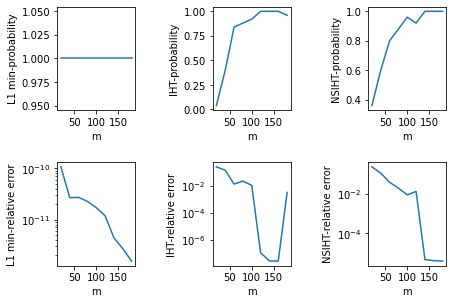

sparsity= 3


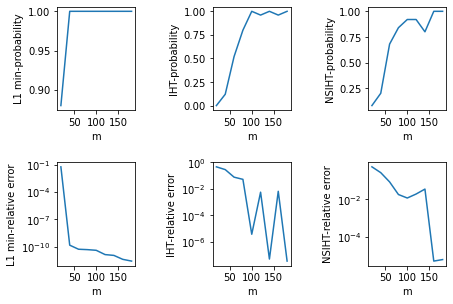

sparsity= 4


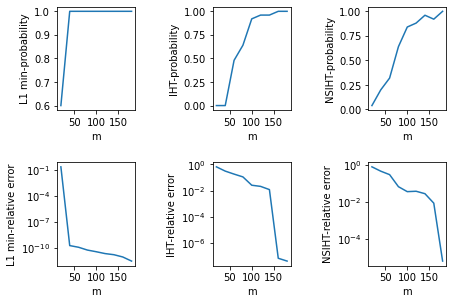

sparsity= 5


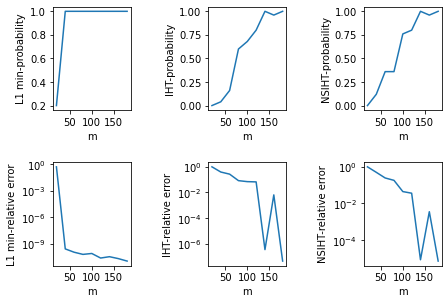

sparsity= 6


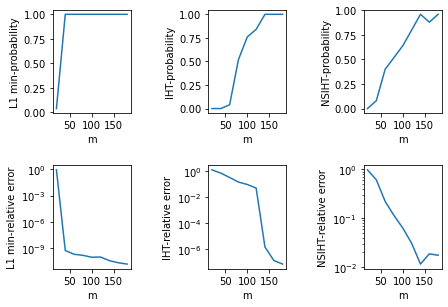

sparsity= 7


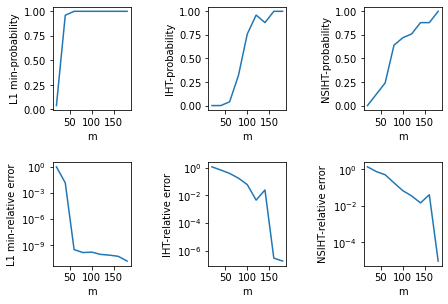

In [9]:
N_mc=25
s_values=[2,3,4,5,6,7]

print('\033[1m' +"PROBABILITY OF RECOVERY AND AVERAGE RELATIVE ERROR AT DIFFERENT VALUES OF SPARSITY FOR L1 min vs IHT vs NSIHT" )
print('')
for spars in s_values:
    
    
    print('sparsity=',(spars))
    
    m_val,prob_l1,diff_l1 =l1_minimization(200,200,spars,25)
    m_iht1,prob_iht1,diff_iht1,resi_iht1=IHT(200,200,spars,25,1)
    m_nsiht1,prob_nsiht1,diff_nsiht1,resi_nsiht1=NSIHT(200,200,spars,25,1,1) 

       

    l1_err= [diff_l1[i:i+N_mc] for i in range(0, len(diff_l1), N_mc)]
    iht_err = [diff_iht1[i:i+N_mc] for i in range(0, len(diff_iht1), N_mc)]
    nsiht_err = [diff_nsiht1[i:i+N_mc] for i in range(0, len(diff_nsiht1), N_mc)]
    
      
    avg_error_l1=[]
    for i in l1_err:
        no=0
        for k in i:
            no=no+k
        avg_error_l1.append(no/25)
    
    avg_error_iht=[]
    for i in iht_err:
        no=0
        for k in i:
            no=no+k
        avg_error_iht.append(no/25)
        
    avg_error_nsiht=[]
    for i in nsiht_err:
        no=0
        for k in i:
            no=no+k
        avg_error_nsiht.append(no/25)
    
    plt.subplot(2,3,1)
    plt.xlabel('m')
    plt.plot(m_iht1,prob_l1)
    plt.ylabel('L1 min-probability')
    
    plt.subplot(2,3,2)
    plt.xlabel('m')
    plt.plot(m_iht1,prob_iht1)
    plt.ylabel('IHT-probability')
        
    plt.subplot(2,3,3)
    plt.xlabel('m')
    plt.plot(m_iht1,prob_nsiht1)
    plt.ylabel('NSIHT-probability')
        
    plt.subplot(2,3,4)
    plt.xlabel('m')
    plt.plot(m_iht1,avg_error_l1)
    plt.ylabel('L1 min-relative error')
    plt.yscale("log")
    
    plt.subplot(2,3,5)
    plt.xlabel('m')
    plt.plot(m_iht1,avg_error_iht)
    plt.ylabel('IHT-relative error')
    plt.yscale("log")

    plt.subplot(2,3,6)
    plt.xlabel('m')
    plt.plot(m_iht1,avg_error_nsiht)
    plt.ylabel('NSIHT-relative error')
    plt.yscale('log')

    plt.subplots_adjust(left=0.1,bottom=0.1,right=1,top=1,wspace=1,hspace=0.5)
    plt.show()
    
    

In [10]:
N_mc=25
s_values=[2,3,5]

s_l1_prob=[]
s_iht_prob=[]
s_nsiht_prob=[]


s_l1_err=[]
s_iht_err=[]
s_nsiht_err=[]

for spars in s_values:
    
    m_val,prob_l1,diff_l1 =l1_minimization(200,200,spars,25)
    m_iht1,prob_iht1,diff_iht1,resi_iht1=IHT(200,200,spars,25,1)
    m_nsiht1,prob_nsiht1,diff_nsiht1,resi_nsiht1=NSIHT(200,200,spars,25,1,1) 

       

    l1_err= [diff_l1[i:i+N_mc] for i in range(0, len(diff_l1), N_mc)]
    iht_err = [diff_iht1[i:i+N_mc] for i in range(0, len(diff_iht1), N_mc)]
    nsiht_err = [diff_nsiht1[i:i+N_mc] for i in range(0, len(diff_nsiht1), N_mc)]
    
      
    avg_error_l1=[]
    for i in l1_err:
        no=0
        for k in i:
            no=no+k
        avg_error_l1.append(no/25)
    
    avg_error_iht=[]
    for i in iht_err:
        no=0
        for k in i:
            no=no+k
        avg_error_iht.append(no/25)
        
    avg_error_nsiht=[]
    for i in nsiht_err:
        no=0
        for k in i:
            no=no+k
        avg_error_nsiht.append(no/25)
    
    s_l1_prob.append(prob_l1)
    s_iht_prob.append(prob_iht1)
    s_nsiht_prob.append(prob_nsiht1)
    
    s_l1_err.append(avg_error_l1)
    s_iht_err.append(avg_error_iht)
    s_nsiht_err.append(avg_error_nsiht)

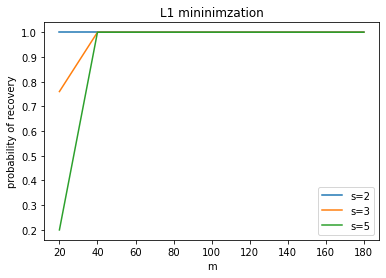

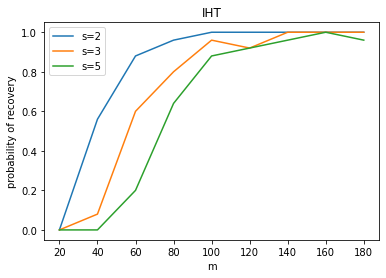

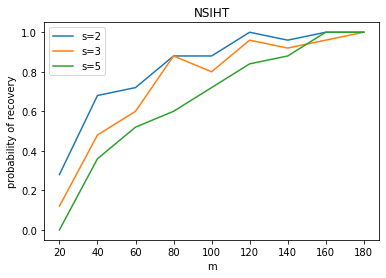

In [11]:
plt.plot(m_val,s_l1_prob[0])
plt.plot(m_val,s_l1_prob[1])
plt.plot(m_val,s_l1_prob[2])
plt.legend(['s=2','s=3','s=5'])
plt.title("L1 mininimzation")
plt.ylabel('probability of recovery')
plt.xlabel('m')
plt.show()

plt.plot(m_val,s_iht_prob[0])
plt.plot(m_val,s_iht_prob[1])
plt.plot(m_val,s_iht_prob[2])
plt.legend(['s=2','s=3','s=5'])
plt.title("IHT")
plt.ylabel('probability of recovery')
plt.xlabel('m')
plt.show()

plt.plot(m_val,s_nsiht_prob[0])
plt.plot(m_val,s_nsiht_prob[1])
plt.plot(m_val,s_nsiht_prob[2])
plt.legend(['s=2','s=3','s=5'])
plt.title("NSIHT")
plt.ylabel('probability of recovery')
plt.xlabel('m')
plt.show()


The above plots compare the probability of recovery for the three algorithms at sparsity levels 2, 3 and 5.

A common observations for the graphs of all the three algorithms show that the recovery of probability reaches closer to 1 when the sparsity level is 2, followed by 3 and then 5.

It is safe to interpret that as the sparsity level increases, the probability of recovery reduces and it is easier to recover a signal of lower sparsity as compared to a signal with a higher probability. 


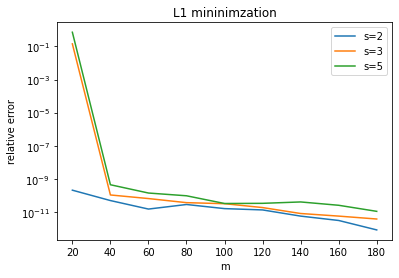

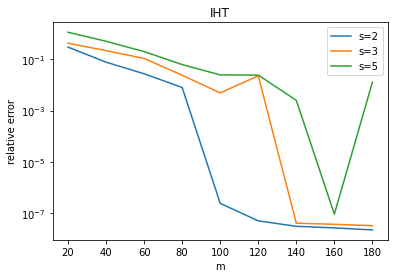

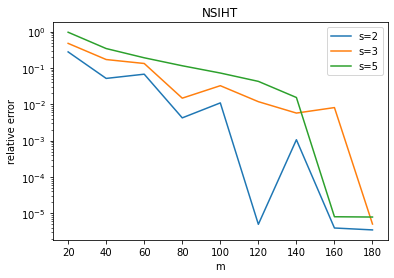

In [12]:
plt.plot(m_val,s_l1_err[0])
plt.plot(m_val,s_l1_err[1])
plt.plot(m_val,s_l1_err[2])
plt.legend(['s=2','s=3','s=5'])
plt.title("L1 mininimzation")
plt.ylabel('relative error')
plt.xlabel('m')
plt.yscale('log')
plt.show()

plt.plot(m_val,s_iht_err[0])
plt.plot(m_val,s_iht_err[1])
plt.plot(m_val,s_iht_err[2])
plt.legend(['s=2','s=3','s=5'])
plt.title("IHT")
plt.ylabel('relative error')
plt.xlabel('m')
plt.yscale('log')
plt.show()

plt.plot(m_val,s_nsiht_err[0])
plt.plot(m_val,s_nsiht_err[1])
plt.plot(m_val,s_nsiht_err[2])
plt.legend(['s=2','s=3','s=5'])
plt.title("NSIHT")
plt.ylabel('relative error')
plt.xlabel('m')
plt.yscale('log')
plt.show()


The above plots compare the average relative errors for the three algorithms with respect to three different sparsity levels.
For each value of m, the algorithm is run N_mc number of times and then we obtain the average values of these relative errors for each value of m at different sparsity levels.

From the graphs, we observe that the relative error for a higher sparsity is more than that of a lower sparsity.
As we increase the sparsity level, the relative errors also increase and exact recovery becomes more difficuilt

We now compare the relative errors of the three algorithms by plotting them as boxplots for a better understanding of the algorithms. 

It shows how the relative error decreases as we increase the value of m

In [13]:
m=200
N=200
s=3
N_mc=15

In [14]:
m_val,prob_l1,diff_l1=l1_minimization(m,N,s,N_mc)
m_ih,prob_iht,diff_iht,resi_2=IHT(m,N,s,N_mc,1)
m_ns,prob_nsiht,diff_nsiht,resi_2=NSIHT(m,N,s,N_mc,1,1)

In [15]:
l1_val = [diff_l1[i:i+N_mc] for i in range(0, len(diff_l1), N_mc)]
iht_val = [diff_iht[i:i+N_mc] for i in range(0, len(diff_iht), N_mc)]
nsiht_val = [diff_nsiht[i:i+N_mc] for i in range(0, len(diff_nsiht), N_mc)]

In [16]:
l1=[]
for i in l1_val:
    for k in i:
        s=math.log10(k)
        l1.append(s)

l1_val = [l1[i:i+N_mc] for i in range(0, len(l1), N_mc)]

iht=[]
for i in iht_val:
    for k in i:
        s=math.log10(k)
        iht.append(s)

iht_val = [iht[i:i+N_mc] for i in range(0, len(iht), N_mc)]

nsiht=[]
for i in nsiht_val:
    for k in i:
        s=math.log10(k)
        nsiht.append(s)

nsiht_val = [nsiht[i:i+N_mc] for i in range(0, len(nsiht), N_mc)]

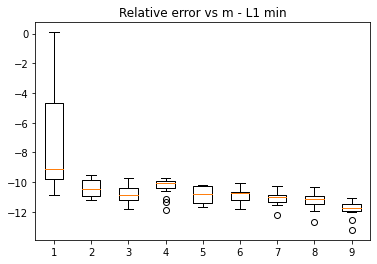

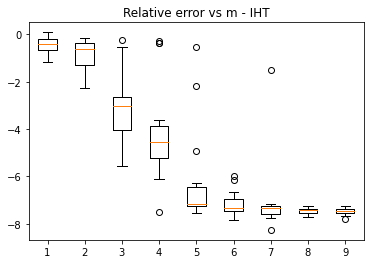

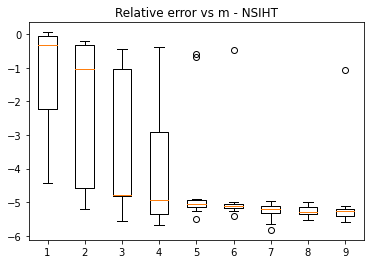

In [17]:
plt.title("Relative error vs m - L1 min")
plt.boxplot(l1_val)
plt.show() 

plt.title("Relative error vs m - IHT")
plt.boxplot(iht_val)
plt.show() 

plt.title("Relative error vs m - NSIHT")
plt.boxplot(nsiht_val)
plt.show() 

The above plots compare the relative errors for L1 minimization, IHT and NSIHT

Following the above observations, we determine the best sparsity levels IHT and NSIHT to be 3. We now compare the two algorithms for a sparsity level 3 by plotting their relative errors and residuals.


In [19]:
m=200
N=200
s=3
N_mc=15

In [20]:
m_ih,prob_iht,diff_iht,resi_iht=IHT(m,N,s,N_mc,1)
m_ns,prob_nsiht,diff_nsiht,resi_nsiht=NSIHT(m,N,s,N_mc,1,1)

In [21]:
iht_val = [resi_iht[i:i+N_mc] for i in range(0, len(resi_iht), N_mc)]
nsiht_val = [resi_nsiht[i:i+N_mc] for i in range(0, len(resi_nsiht), N_mc)]

In [22]:
iht=[]
for i in iht_val:
    for k in i:
        s=math.log10(k)
        iht.append(s)

iht_val = [iht[i:i+N_mc] for i in range(0, len(iht), N_mc)]

nsiht=[]
for i in nsiht_val:
    for k in i:
        s=math.log10(k)
        nsiht.append(s)

nsiht_val = [nsiht[i:i+N_mc] for i in range(0, len(nsiht), N_mc)]

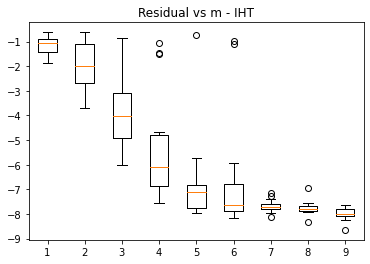

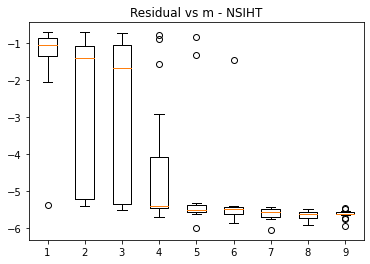

In [23]:
plt.title("Residual vs m - IHT")
plt.boxplot(iht_val)
plt.show() 

plt.title("Residual vs m - NSIHT")
plt.boxplot(nsiht_val)
plt.show() 

The above plots compare the residual for IHT and NSIHT algorithms

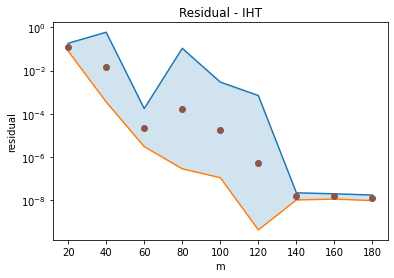

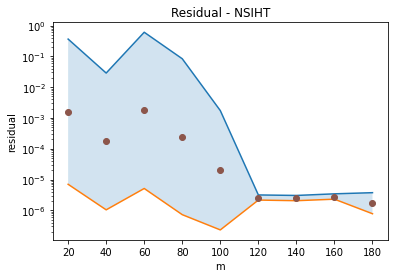

In [24]:
N_mc=5

m_iht2,prob_iht2,diff_iht2,resi_iht2=IHT(200,200,3,5,1)
m_nsiht2,prob_nsiht2,diff_nsiht2,resi_nsiht2=NSIHT (200,200,3,5,1,1)

iht_res_val = [resi_iht2[i:i+5] for i in range(0, len(resi_iht2), 5)]
nsiht_res_val = [resi_nsiht2[i:i+5] for i in range(0, len(resi_nsiht2), 5)]

mean=[]
sd=[]
iht=[]

for i in iht_res_val:
    for k in i:
        no=math.log10(k)
        iht.append(no)
val = [iht[i:i+5] for i in range(0, len(iht), 5)]

for i in val:
    #for k in i:
    m=statistics.mean(i)
    mean.append(m)
    s=statistics.stdev(i)
    sd.append(s)

ui=[]
for i in mean:
    s=pow(10,i)
    ui.append(s)
    
sd_p=[]
sd_m=[]
for i in range(9):
    sp=mean[i]+sd[i]
    sd_p.append(pow(10,sp))
    sm=mean[i]-sd[i]
    sd_m.append(pow(10,sm))

plt.plot( m_iht2,sd_p)
plt.plot(m_iht2,sd_m)
plt.fill_between( m_iht2,sd_p, sd_m,
                 alpha=0.2)
plt.plot(m_iht2, ui, 'o', color='tab:brown')
plt.yscale('log')
plt.title("Residual - IHT")
plt.xlabel("m")
plt.ylabel("residual")
plt.show()

mean=[]
sd=[]
nsiht=[]

for i in nsiht_res_val:
    for k in i:
        no=math.log10(k)
        nsiht.append(no)
val = [nsiht[i:i+5] for i in range(0, len(nsiht), 5)]

for i in val:
    #for k in i:
    m=statistics.mean(i)
    mean.append(m)
    s=statistics.stdev(i)
    sd.append(s)

ui=[]
for i in mean:
    s=pow(10,i)
    ui.append(s)
    
sd_p=[]
sd_m=[]
for i in range(9):
    sp=mean[i]+sd[i]
    sd_p.append(pow(10,sp))
    sm=mean[i]-sd[i]
    sd_m.append(pow(10,sm))

plt.plot( m_iht2,sd_p)
plt.plot(m_iht2,sd_m)
plt.fill_between( m_iht2,sd_p, sd_m,
                 alpha=0.2)
plt.plot(m_iht2, ui, 'o', color='tab:brown')
plt.yscale('log')
plt.title("Residual - NSIHT")
plt.xlabel("m")
plt.ylabel("residual")
plt.show()

The above plot shows the values of residual as the value of m varies.

We first calculate the mean residual for each value of m, as shown by the brown dots. Using these mean values, we also calculate the standard deviation and plot the deviation plots, represented by the blue and orange lines. The shaded regions between these lines show the deviation of residual from their mean values. 

We observe the shaded region decrease as m increases. This suggests that as we increase m, recovery becomes easier and the deviation decreases. 

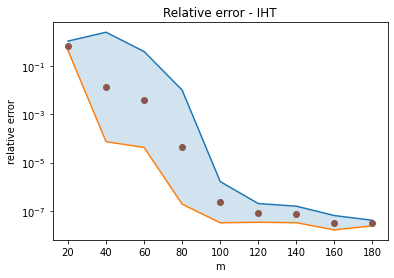

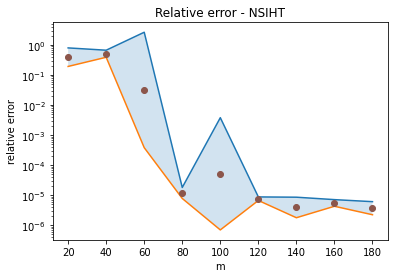

In [25]:
N_mc=5

m_iht2,prob_iht2,diff_iht2,resi_iht2=IHT(200,200,3,5,1)
m_nsiht2,prob_nsiht2,diff_nsiht2,resi_nsiht2=NSIHT (200,200,3,5,1,1)

iht_err_val = [diff_iht2[i:i+5] for i in range(0, len(diff_iht2), 5)]
nsiht_err_val = [diff_nsiht2[i:i+5] for i in range(0, len(diff_nsiht2), 5)]

mean=[]
sd=[]
iht=[]

for i in iht_err_val:
    for k in i:
        no=math.log10(k)
        iht.append(no)
val = [iht[i:i+5] for i in range(0, len(iht), 5)]

for i in val:
    #for k in i:
    m=statistics.mean(i)
    mean.append(m)
    s=statistics.stdev(i)
    sd.append(s)

ui=[]
for i in mean:
    s=pow(10,i)
    ui.append(s)
    
sd_p=[]
sd_m=[]
for i in range(9):
    sp=mean[i]+sd[i]
    sd_p.append(pow(10,sp))
    sm=mean[i]-sd[i]
    sd_m.append(pow(10,sm))

plt.plot( m_iht2,sd_p)
plt.plot(m_iht2,sd_m)
plt.fill_between( m_iht2,sd_p, sd_m,
                 alpha=0.2)
plt.plot(m_iht2, ui, 'o', color='tab:brown')
plt.yscale('log')
plt.title("Relative error - IHT")
plt.xlabel("m")
plt.ylabel("relative error")
plt.show()

mean=[]
sd=[]
nsiht=[]

for i in nsiht_err_val:
    for k in i:
        no=math.log10(k)
        nsiht.append(no)
val = [nsiht[i:i+5] for i in range(0, len(nsiht), 5)]

for i in val:
    #for k in i:
    m=statistics.mean(i)
    mean.append(m)
    s=statistics.stdev(i)
    sd.append(s)

ui=[]
for i in mean:
    s=pow(10,i)
    ui.append(s)
    
sd_p=[]
sd_m=[]
for i in range(9):
    sp=mean[i]+sd[i]
    sd_p.append(pow(10,sp))
    sm=mean[i]-sd[i]
    sd_m.append(pow(10,sm))

plt.plot( m_iht2,sd_p)
plt.plot(m_iht2,sd_m)
plt.fill_between( m_iht2,sd_p, sd_m,
                 alpha=0.2)
plt.plot(m_iht2, ui, 'o', color='tab:brown')
plt.yscale('log')
plt.title("Relative error - NSIHT")
plt.xlabel("m")
plt.ylabel("relative error")
plt.show()

The above plot shows the values of relative error as the value of m varies.

We first calculate the mean relative error for each value of m, as shown by the brown dots. Using these mean values, we also calculate the standard deviation and plot the deviation plots, represented by the blue and orange lines. The shaded regions between these lines show the deviation of relative error from their mean values.

We observe the shaded region decrease as m increases. This suggests that as we increase m, recovery becomes easier and the deviation decreases.

In [26]:
m=200
N=200
s=3
N_mc=5
h=1
e=1


In [27]:
def iht_vs_nsiht(m,N,s,N_mc,h,e):
    
    iht_rel_err=[]
    iht_resi=[]
    
    nsiht_rel_err=[]
    nsiht_resi=[]
    
    for i in range(N_mc):
    
        iteration=0
        max_iter=160
        tol=1e-10

        iht_res_val=[]
        nsiht_res_val=[]

        A=np.random.randn(m,N) # measurement matrix
        x =np.zeros((N,1))
        a=LA.norm(A,2)
        A=A/(a)

        import random
        randomlist = random.sample(range(0, N-1), s) # indeces for non zero value
        from random import random

        for i in randomlist:
            x[i]=random()  

        y=A.dot(x)  

        xn_iht=np.zeros((N,1))
        xn1_iht=np.zeros((N,1)) #xn+1

        xn_iht=np.zeros((N,1))
        rel_err_iht=[]
        resi_iht=[]
        rel_incr=10

        xn1_iht=np.zeros((N,1)) #xn+1

        while iteration<max_iter and rel_incr>tol:
            A_trans=A.transpose()
            xn1_iht=xn_iht+(h*(A_trans.dot((y-(A.dot(xn_iht))))))
            xn1_iht=hard_thresh(xn1_iht,s)

            resi_iht.append(LA.norm((A.dot(xn1_iht))-y))       
            rel_err_iht.append(LA.norm(xn_iht-x))
            iteration=iteration+1       
            xn_iht=xn1_iht
            
        iht_rel_err.append(rel_err_iht)
        iht_resi.append(resi_iht)    

        xn_nsiht=np.zeros((N,1))
        resi_nsiht=[]
        rel_err_nsiht=[]

        rel_incr=10

        iteration=0
        I=np.identity(N)
        xn1_nsiht=np.zeros((N,1)) #xn+1

        while iteration<max_iter and rel_incr>tol:

            A_trans=A.transpose()
            inv=(A_trans.dot(A))+(e*I)
            inv=np.linalg.inv(inv) 
            xn1_nsiht=xn_nsiht+(h*inv.dot((A_trans.dot(y-A.dot(xn_nsiht)))))      
            xn1_nsiht=hard_thresh(xn1_nsiht,s)

            resi_nsiht.append(LA.norm((A.dot(xn1_nsiht))-y))
            iteration=iteration+1
            rel_err_nsiht.append(LA.norm(xn_nsiht-x))
            xn_nsiht=xn1_nsiht
            
        nsiht_rel_err.append(rel_err_nsiht)
        nsiht_resi.append(resi_nsiht)

    return iht_rel_err, iht_resi, nsiht_rel_err, nsiht_resi

In [28]:
resi_iht,resi_nsiht,rel_err_iht,rel_err_nsiht=iht_vs_nsiht(m,N,s,N_mc,h,e)

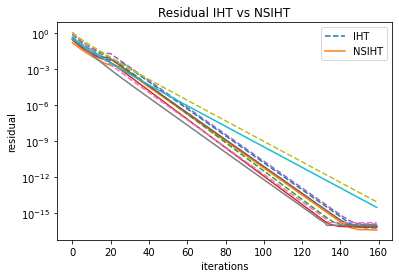

In [29]:
for i in range(N_mc):
    plt.plot(resi_iht[i],'--')
    plt.plot(resi_nsiht[i])
plt.legend(['IHT', 'NSIHT'])
plt.title('Residual IHT vs NSIHT')
plt.xlabel('iterations')
plt.ylabel('residual')
plt.yscale('log')

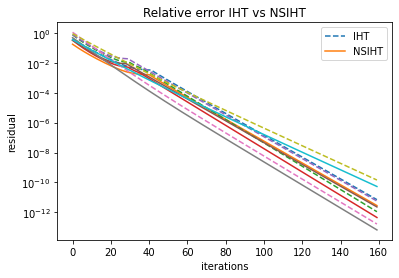

In [30]:
for i in range(N_mc):
    plt.plot(rel_err_iht[i],'--')
    plt.plot(rel_err_nsiht[i])
plt.legend(['IHT', 'NSIHT'])
plt.title('Relative error IHT vs NSIHT')
plt.xlabel('iterations')
plt.ylabel('residual')
plt.yscale('log')

The above plots compare the value of residual and relative error for IHT and NSIHT compared to the iteration for the algorithms. The dotted lines represent the IHT algorithm and the continuous ones the NSIHT algorithms. On observing the two plots, we can interpret that for the common parameters, the NSIHT algorithms, though slightly, work better and more efficiently than the IHT algorithm

Define the function recovery_plots to plot the probability of recover for the algorithms vs the value of m

In [31]:
def recovery_plots(m_val,prob_l1,prob_iht,prob_nsiht):
    plt.title('Probability of recovery',fontsize=20)

    # plot the probability of success for the three algorithms vs the values of m to show the probability at different values of m
    plt.plot(m_val,prob_l1)
    plt.plot(m_val,prob_iht)
    plt.plot(m_val,prob_nsiht)


    plt.legend(['L1 min', 'IHT', 'NSIHT'])
    plt.xlabel('m')
    plt.ylabel('recovery probability ')

    plt.show()

Define the function relative_error to plot the difference between the x vector recovered and calculated x for N_mc no of times at the various values of m

In [32]:
def relative_error(diff_l1,diff_iht,diff_nsiht,N_mc,m):
    
    #split the values of difference between the vector x calculated and obtained for each iteration, at different values for m as separate lists
    l1_val = [diff_l1[i:i+N_mc] for i in range(0, len(diff_l1), N_mc)]
    iht_val = [diff_iht[i:i+N_mc] for i in range(0, len(diff_iht), N_mc)]
    nsiht_val = [diff_nsiht[i:i+N_mc] for i in range(0, len(diff_nsiht), N_mc)]
    
    k=len(l1_val) 
    v=[]
    
    for i in range(20,m,20):
        v.append(i) 
        
    j=int(N_mc-1)/2
    j=int(j)
    
    print('\033[1m' +"ERROR IN RECOVERY AT DIFFERENT VALUES FOR m" )
    for i in range(k):
        plt.title( v[i],fontsize=13)    
        plt.plot(l1_val[i])
        plt.plot(iht_val[i])
        plt.plot(nsiht_val[i])
        plt.yscale('log')
        plt.legend(['L1 min', 'IHT', 'NSIHT'])
        plt.ylabel('relative error')
        plt.xlabel('iteratios')
        plt.show()

    

We now compare the three algorithms for the best sparsity level i.e 3

In [33]:
m=200
N=200
s=3
N_mc=25

In [35]:
m_val,prob_l1,diff_l1=l1_minimization(m,N,s,N_mc)

In [36]:
m_i,prob_iht,diff_iht,resi_1=IHT(m,N,s,N_mc,1)

In [38]:
ms,prob_nsiht,diff_nsiht,resi1=NSIHT(m,N,s,N_mc,1,1)

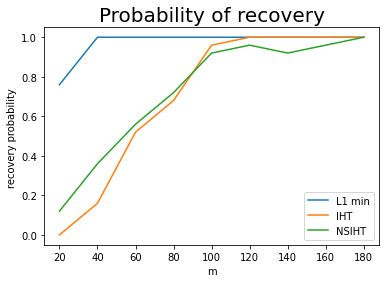

In [39]:
recovery_plots(m_val,prob_l1,prob_iht,prob_nsiht)

The above plot compares probability of recovery for L1 minimization, IHT and NSIHT for sparsity level 3

ERROR IN RECOVERY AT DIFFERENT VALUES FOR m


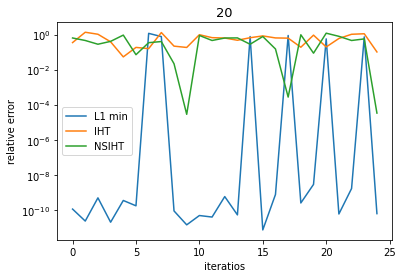

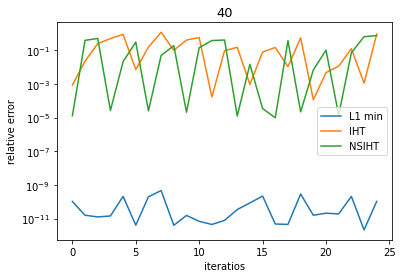

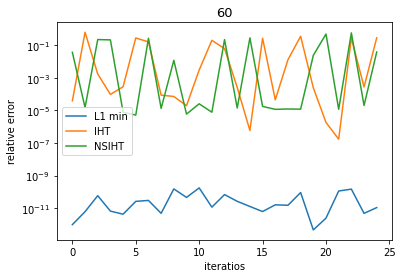

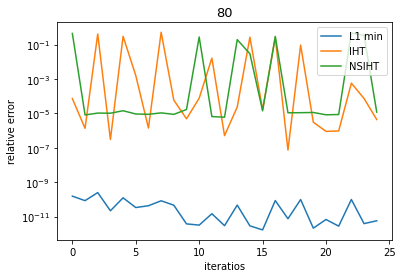

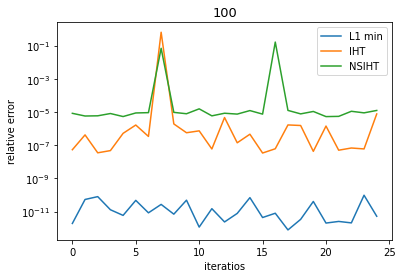

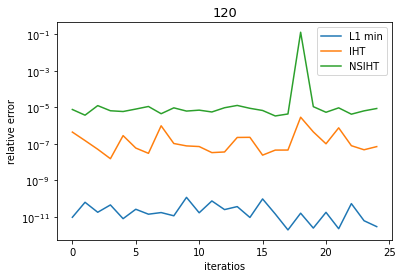

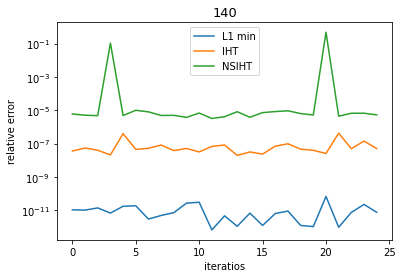

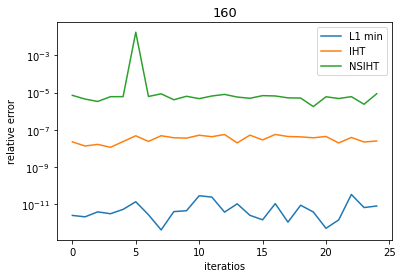

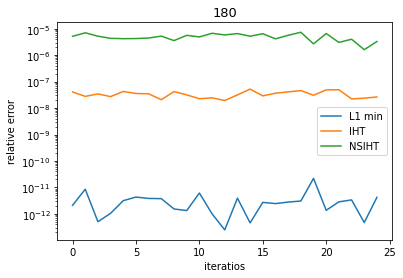

In [40]:
relative_error(diff_l1,diff_iht,diff_nsiht,N_mc,m)

The above plot compares the relative error for L1 minimization, IHT and NSIHT for sparsity level 3 at different values of m

Comparison of algorithms for s=5

In [45]:
m=200
N=200
s=5
N_mc=25

In [46]:
m_val,prob_l1,diff_l1=l1_minimization(m,N,s,N_mc)

In [47]:
m_ih,prob_iht,diff_iht,resi_2=IHT(m,N,s,N_mc,1)

In [48]:
m_ns,prob_nsiht,diff_nsiht,resi_2=NSIHT(m,N,s,N_mc,1,1)

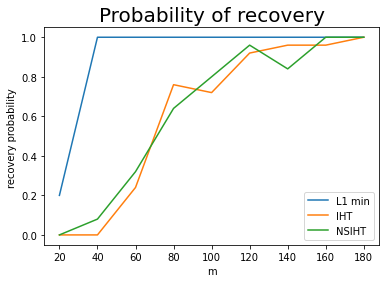

In [49]:
recovery_plots(m_val,prob_l1,prob_iht,prob_nsiht)

The above plot compares probability of recovery for L1 minimization, IHT and NSIHT for sparsity level 5

ERROR IN RECOVERY AT DIFFERENT VALUES FOR m


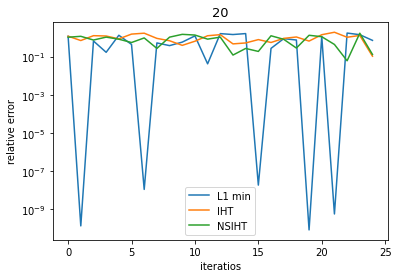

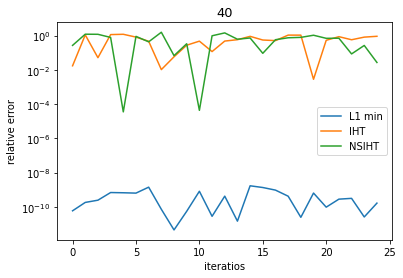

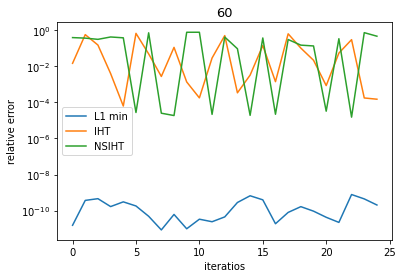

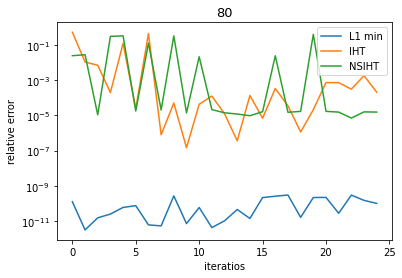

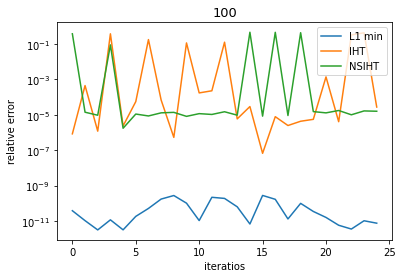

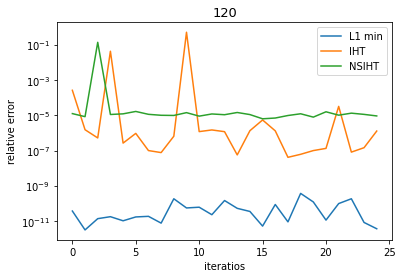

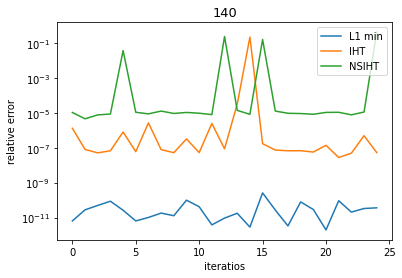

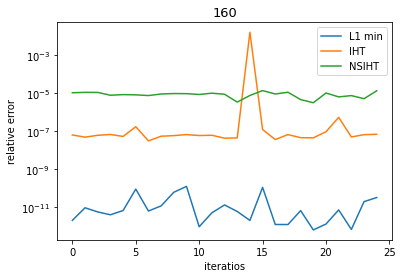

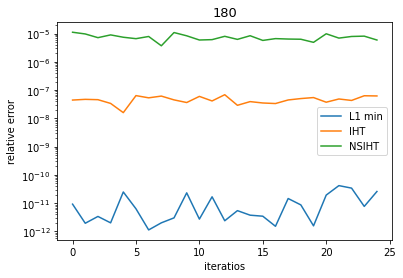

In [50]:
relative_error(diff_l1,diff_iht,diff_nsiht,N_mc,m)

The above plot compares the relative errors for L1 minimization, IHT and NSIHT for sparsity level 5

In [51]:
print("BIBLIOGRAPHY" )
display(HTML("""<a href="https://users.math.msu.edu/users/iwenmark/Teaching/MTH994/Holger_Simon_book.pdf">Simon Foucart, Holger Rauhut. "A Mathematical Introduction to Compressive Sensing". 2013
</a>"""))

display(HTML("""<a href="hhttps://www.sciencedirect.com/science/article/pii/S1063520309000384">Thomas Blumensath, Mike E. DavieS. "Iterative hard thresholding for compressed sensing"</a>"""))

display(HTML("""<a href="https://arxiv.org/pdf/2001.07181.pdf">Nan Meng, Yun-Bin Zhao. "Newton-Step-Based Hard Thresholding Algorithms for Sparse Signal Recovery"
</a>"""))

BIBLIOGRAPHY
